In [ ]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
plt.rcParams["axes.grid"] = False
np.random.seed(101)

In [ ]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [ ]:
import glob
from PIL import Image
import numpy as np

# Assuming trainx and trainy directories contain only image files
filelist_trainx = sorted(glob.glob('/content/drive/MyDrive/trainx/*.bmp'), key=numericalSort)
X_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainx])

filelist_trainy = sorted(glob.glob('/content/drive/MyDrive/trainy/*.bmp'), key=numericalSort)
Y_train = np.array([np.array(Image.open(fname)) for fname in filelist_trainy])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25)

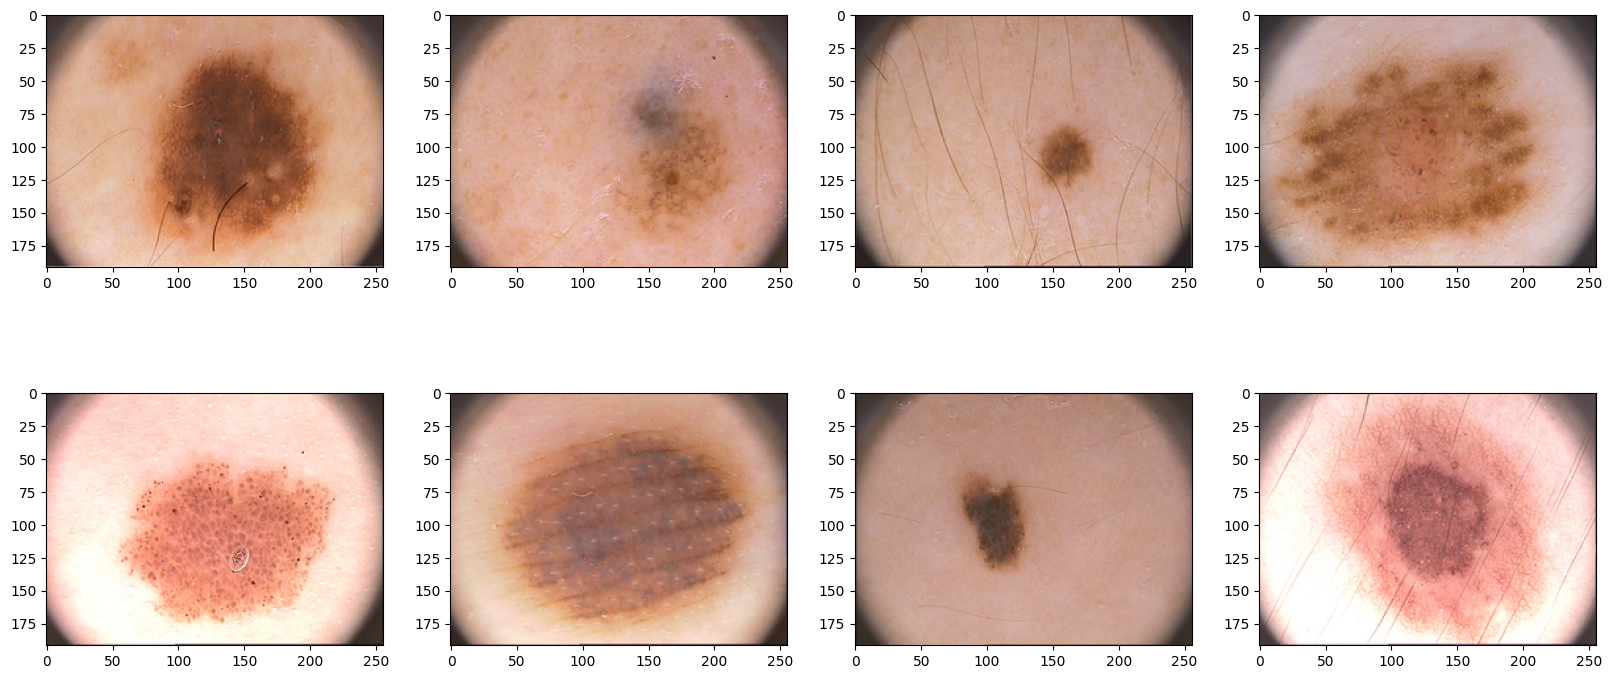

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()


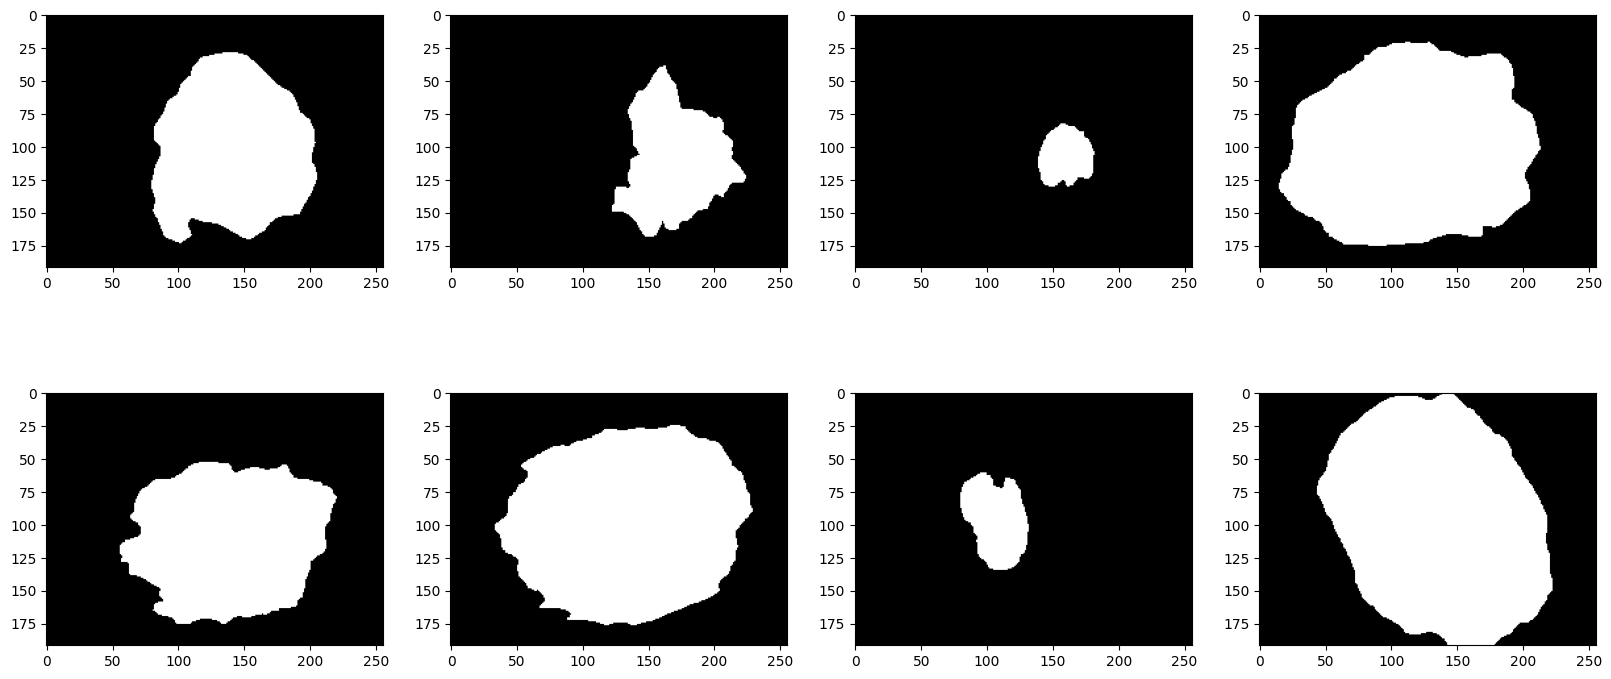

In [ ]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()


In [ ]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

In [ ]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [ ]:
def dice_coef(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [ ]:
def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [ ]:
def accuracy(y_true, y_pred):
    '''Calculates the mean accuracy rate across all predictions for binary
    classification problems.
    '''
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [ ]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [ ]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)

        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
        return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [ ]:
def img_augmentation(x_test, y_test):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    x_nois = []
    for idx in range(len(x_test)):
        x,y = random_rotation(x_test[idx], y_test[idx])
        x_rotat.append(x)
        y_rotat.append(y)

        x,y = horizontal_flip(x_test[idx], y_test[idx])
        x_flip.append(x)
        y_flip.append(y)

    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)


In [ ]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)
x_rotated_t, y_rotated_t, x_flipped_t, y_flipped_t = img_augmentation(x_test, y_test)

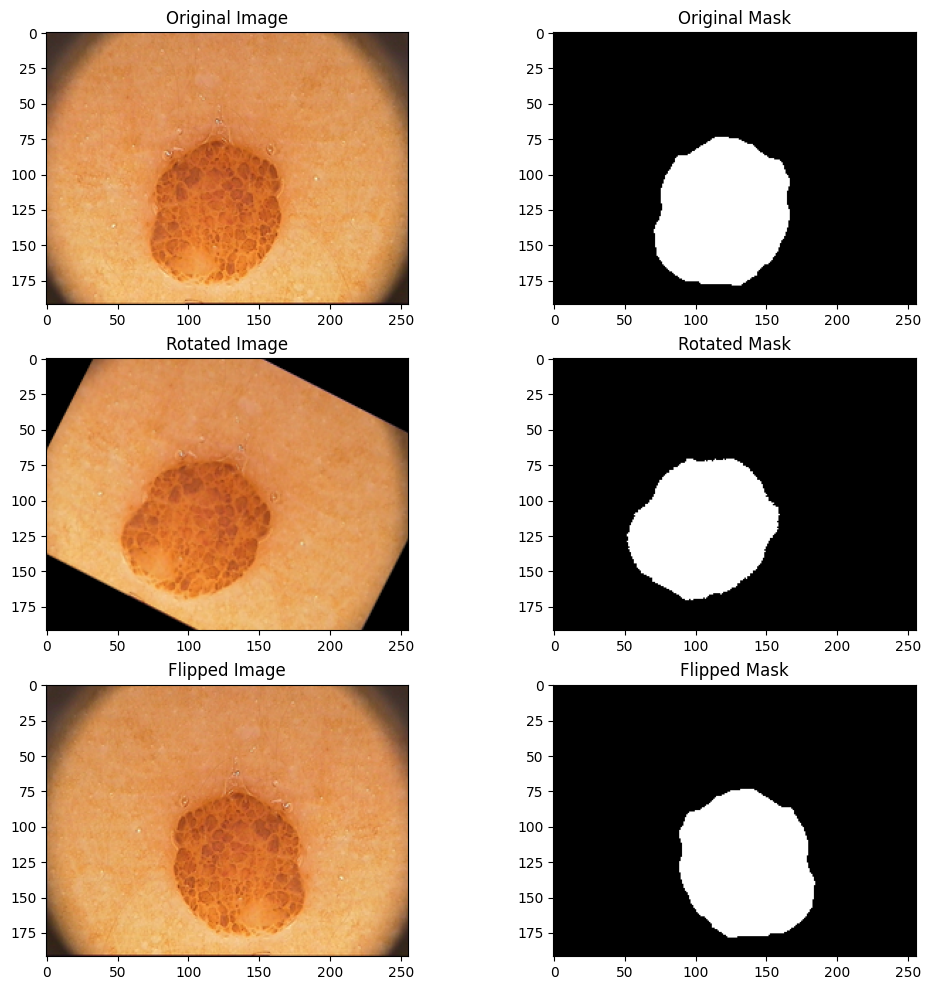

In [ ]:
img_num = 114
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()


In [ ]:
# For training Set
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [ ]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


In [ ]:
def fcn_net(epochs_num,savename):

    # Convolution Layers (BatchNorm after non-linear activation)

    img_input = Input(shape= (192, 256, 3))
    x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dropout(0.5)(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)

    # Deconvolution Layers (BatchNorm after non-linear activation)

    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = UpSampling2D()(x)
    x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn9')(x)

    x = Dropout(0.5)(x)

    x = Activation('sigmoid')(x)
    pred = Reshape((192,256))(x)
    model = Model(inputs=img_input, outputs=pred)

    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coef, precision, recall, accuracy])

    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 18, validation_data= (x_val, y_val), verbose=1)

    model.save(savename)
    return model,hist

In [ ]:
import tensorflow.keras.backend as K

def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(K.cast(y_true, 'float32') * K.cast(y_pred, 'float32')), axis=-1)
    sum_ = K.sum(K.square(K.cast(y_true, 'float32')), axis=-1) + K.sum(K.square(K.cast(y_pred, 'float32')), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth
model, hist = fcn_net(epochs_num= 1, savename= 'fcn_1_epochs.h5')

In [ ]:
img_input = Input(shape= (192, 256, 3))
x = Conv2D(16, (5, 5), padding='same', name='conv1',strides= (1,1))(img_input)
x = BatchNormalization(name='bn1')(x)
x = Activation('relu')(x)
x = Conv2D(32, (3, 3), padding='same', name='conv2')(x)
x = BatchNormalization(name='bn2')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (4, 4), padding='same', name='conv3')(x)
x = BatchNormalization(name='bn3')(x)
x = Activation('relu')(x)
x = Conv2D(64, (4, 4), padding='same', name='conv4')(x)
x = BatchNormalization(name='bn4')(x)
x = Activation('relu')(x)
x = MaxPooling2D()(x)

x = Dropout(0.5)(x)
x = Conv2D(512, (3, 3), padding='same', name='conv5')(x)
x = BatchNormalization(name='bn5')(x)
x = Activation('relu')(x)
x = Dense(1024, activation = 'relu', name='fc1')(x)
x = Dense(1024, activation = 'relu', name='fc2')(x)

# Deconvolution Layers (BatchNorm after non-linear activation)

x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv1')(x)
x = BatchNormalization(name='bn6')(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv2')(x)
x = BatchNormalization(name='bn7')(x)
x = Activation('relu')(x)
x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv3')(x)
x = BatchNormalization(name='bn8')(x)
x = Activation('relu')(x)
x = UpSampling2D()(x)
x = Conv2DTranspose(1, (3, 3), padding='same', name='deconv4')(x)
x = BatchNormalization(name='bn9')(x)

x = Dropout(0.5)(x)

x = Activation('sigmoid')(x)
pred = Reshape((192,256))(x)

In [ ]:
model_0 = Model(inputs=img_input, outputs=pred)
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance], metrics=[iou, dice_coef, precision, recall, accuracy])

In [ ]:
model_0.load_weights('fcn_1_epochs.h5')

In [ ]:
print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 407s 20s/step - loss: 35.1717 - iou: 0.6483 - dice_coef: 0.0038 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.6769
________________________
IOU:       |   64.83  |
Dice Coef: |   0.38  |
Precision: |   0.00  |
Recall:    |   0.00  |
Accuracy:  |   67.69  |
Loss:      |   3517.17  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 56s 17s/step - loss: 34.5483 - iou: 0.6545 - dice_coef: 0.0087 - precision: 0.2214 - recall: 8.4326e-04 - accuracy: 0.6844
________________________
IOU:       |   65.45  |
Dice Coef: |   0.87  |
Precision: |   22.14  |
Recall:    |   0.08  |
Accuracy:  |   68.44  |
Loss:      |   3454.83  |
________________________

-------------On validation Set---------------------

5/5 [==============================] - 107s 21s/step - loss: 34.4